In [542]:
import importlib
import pandas as pd
import modules.df_functions
import modules.plot_functions

# Reload user defined functions -- because notebooks keep a cached version of functions otherwise
importlib.reload(modules.df_functions)
importlib.reload(modules.plot_functions)
get_repo = modules.df_functions.get_repo
get_repo_from_source = modules.df_functions.get_repo_from_source
plot = modules.plot_functions.plot

In [543]:
path = r"C:\Users\Tom\documents\coding\cityalarms\.git"
path2 = "https://github.com/tommcdee/AI_search"
react = "https://github.com/facebook/react.git"
bluesky = "https://github.com/bluesky-social/social-app"

In [552]:
penalties = ("new typescript", 0.5)
df, df_full = get_repo(
    path, penalties=penalties, start=1, end=-1, full_info=True, all_dates=True
)

In [553]:
df2 = get_repo(path2, group="year", all_dates=True)

In [558]:
df3 = get_repo(bluesky, group="month", all_dates=True, author="Paul")

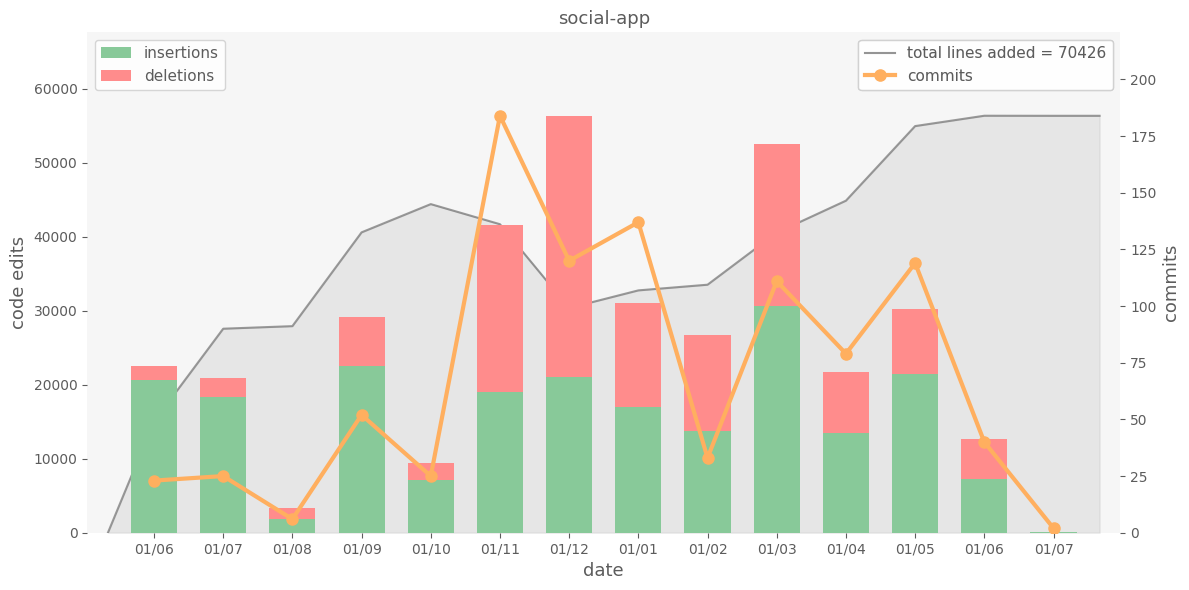

In [560]:
plot(df3)